In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../../")

In [10]:
from torchganime.models.vqgan import VQGAN
from torchganime.models.ganime import VideoTransformer, VideoTransformerConfig
import torch
import matplotlib.pyplot as plt
from torchganime.data.dataloader.video import VideoData
from torchvision.utils import make_grid
import torchvision

In [4]:
vqgan = VQGAN.load_from_checkpoint("/TorchGANime/checkpoints/vqgan_full/checkpoints/epoch=199-step=168800.ckpt")

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
loaded pretrained LPIPS loss from /TorchGANime/torchganime/models/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [192]:
video_data = VideoData("/TorchGANime/data/kny/raw_videos/02.mkv", "/TorchGANime/data/kny/raw_videos/02.mkv", image_size=(128, 256), batch_size=16)

2023-01-08 14:53:33.664 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos
2023-01-08 14:53:34.891 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos


In [193]:
b, target = next(iter(video_data.train_dataloader()))

In [203]:
frame_number = b["frame_number"][[0,3,4]]
first_frames = b["first_frame"][[0,3,4]]
end_frames = b["end_frame"][[0,3,4]]

In [204]:

grid = torchvision.utils.make_grid(first_frames)

In [205]:
first_frames.shape

torch.Size([3, 3, 128, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


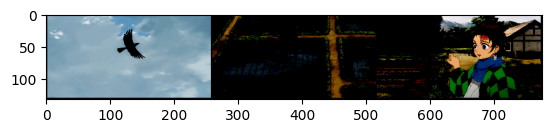

In [206]:
plt.imshow(grid.permute(1, 2, 0).detach().numpy())

In [207]:
def encode(frame):
    quant_z, _, info = vqgan.encode(frame)
    indices = info[2].view(quant_z.shape[0], -1)
    return quant_z, indices

In [208]:
first_frames_quant, first_frames_indices = encode(first_frames)
_, end_frames_indices = encode(end_frames)

In [209]:
i = 5
remaining_frames = frame_number - i

In [210]:
input = torch.stack((first_frames_indices, end_frames_indices), dim=1)

In [211]:
input.shape

torch.Size([3, 2, 512])

In [429]:
video_data = VideoData("/TorchGANime/data/kny/raw_videos/02.mkv", "/TorchGANime/data/kny/raw_videos/02.mkv", image_size=(128, 256), batch_size=16)

2023-01-15 11:46:20.511 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos
2023-01-15 11:46:24.408 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos


In [432]:
for batch in video_data.train_dataloader():
    b = batch
    break

In [433]:
b[0]["remaining_frames"]

tensor([13, 15,  1,  4,  5,  5,  1,  5,  9, 10, 13,  0, 10, 13,  1, 12])

In [438]:
b[0]["current_frame"].shape

torch.Size([16, 3, 128, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


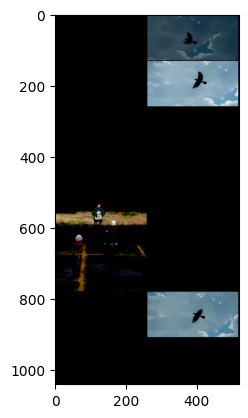

In [444]:
plt.imshow( torchvision.utils.make_grid(b[0]["current_frame"], nrow=2).permute(1, 2, 0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


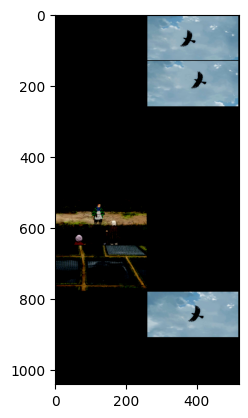

In [445]:
plt.imshow( torchvision.utils.make_grid(b[0]["end_frame"], nrow=2).permute(1, 2, 0).detach().numpy())

In [446]:
remaining_frames = b[0]["remaining_frames"]

In [447]:
remaining_frames.shape

torch.Size([16])

In [448]:
indices = torch.rand((16, 512))

In [449]:
indices.shape

torch.Size([16, 512])

In [459]:
torch.cat((remaining_frames[:, None], indices), dim=1).shape

torch.Size([16, 513])

In [458]:
remaining_frames[:, None].shape

torch.Size([16, 1])

In [543]:
from torchganime.models.ganime import VideoTransformer, VideoTransformerConfig
transformer = VideoTransformer(VideoTransformerConfig(learning_rate= 5e-4,
  vqgan_ckpt_path= "/TorchGANime/checkpoints/vqgan_full/checkpoints/checkpoint.ckpt",
  transformer_ckpt_path= "gpt2",
  use_token_type_ids= True))

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
loaded pretrained LPIPS loss from /TorchGANime/torchganime/models/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


2023-01-15 16:12:59.978 | INFO     | torchganime.models.video_transformer:__init__:109 - Loaded transformer from gpt2 with 
            50257 tokens
            1024 positions
            768 embedding dimensions
            12 layers
            12 heads
            124M parameters


loaded pretrained LPIPS loss from /TorchGANime/torchganime/models/lpips/vgg.pth


In [545]:
current_frames = torch.rand((4, 3, 128, 256))
end_frames  = torch.rand((4, 3, 128, 256))
remaining_frames = torch.randint(1, 15, (4,))
target= torch.rand((4, 3, 128, 256))
output = transformer(current_frames, end_frames, remaining_frames, target)

In [511]:
output["next_frame"].shape

torch.Size([4, 3, 128, 256])

In [512]:
output["loss"]

tensor(10.4421, grad_fn=<AddBackward0>)

In [513]:
output["nll_loss"]

tensor(0.9966)

In [526]:
torch.tensor(5).repeat(4)

tensor([5, 5, 5, 5])

In [532]:
def sample(first_frames, end_frames, frame_number):
    batch_size = first_frames.shape[0]
    frame_number = torch.tensor(frame_number).repeat(batch_size)
    generated_video = [first_frames]
    for i in range(1, frame_number.max()):
        output = transformer(
            generated_video[-1], end_frames, frame_number - i
        )
        generated_video.append(output["next_frame"])
    return torch.stack(generated_video, dim=2)

In [534]:
generated_video = sample(current_frames, end_frames= end_frames, frame_number=2)

In [535]:
generated_video.shape

torch.Size([4, 3, 3, 128, 256])

In [536]:
d = {"nll_loss": 5, "loss": 2, "p_loss": 3}

In [537]:
{key: value for key, value in d.items() if "_loss" in key}

{'nll_loss': 5, 'p_loss': 3}

In [6]:
from torchganime.data.dataset.video import SceneDataset
from torchvision import transforms
from torchvision.transforms import _transforms_video as video_transforms
train_dataset = SceneDataset(
    ["/TorchGANime/data/kny/raw_videos/02.mkv"],
    transforms.Compose(
                [
                    video_transforms.ToTensorVideo(),
                    transforms.Resize((128, 256)),
                ]),
    recursive=True,
    show_progress=True,
    # min_max_len=(15, 25),
    detector="content",
    threshold=15,
    min_scene_len=15,
)

2023-01-18 08:10:13.485 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos


In [50]:
# plt.imshow(torchvision.utils.make_grid(train_dataset[0].permute(1, 0, 2, 3), nrow=3).permute(1, 2, 0))
for i in range(30):
    start = train_dataset.scenes[i].start
    end = train_dataset.scenes[i].end
    plt.imsave(f"/TorchGANime/notebooks/model/images/{i:03d}__{start:04d}_{end:04d}.png", torchvision.utils.make_grid(train_dataset[i].permute(1, 0, 2, 3), nrow=1).permute(1, 2, 0).detach().numpy())

In [7]:
train_dataset[15].shape

torch.Size([3, 230, 128, 256])

In [17]:
from torch.nn import functional as F

mse_loss = 0
video = train_dataset[3]
for i in range(video.shape[1] - 1):
    mse_loss += F.mse_loss(video[:, i], video[:, i + 1])
mse_loss

tensor(0.0903)

In [39]:
!ffmpeg -i /TorchGANime/notebooks/model/02.mkv -vf decimate=cycle=2,setpts=N/25/TB /TorchGANime/notebooks/model/out.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [49]:
from torchganime.data.dataset.video import SceneDataset
from torchvision import transforms
from torchvision.transforms import _transforms_video as video_transforms
train_dataset = SceneDataset(
    ["/TorchGANime/notebooks/model/02.mkv"],
    transforms.Compose(
                [
                    video_transforms.ToTensorVideo(),
                    transforms.Resize((128, 256)),
                ]),
    recursive=True,
    show_progress=True,
    # min_max_len=(15, 25),
    detector="content",
    threshold=15,
    min_scene_len=15,
)

2023-01-18 13:44:26.778 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos
2023-01-18 13:44:26.780 | INFO     | torchganime.data.dataset.video:detect_scenes:245 - Detecting scenes in /TorchGANime/notebooks/model/02.mkv...
Detected: 401 | Progress: 100%|█████████▉| 34047/34049 [00:20<00:00, 1655.83frames/s]


In [24]:
len(train_dataset)

528